# Outlier Detection
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

https://scikit-learn.org/stable/modules/outlier_detection.html

**Inliers are labeled 1, while outliers are labeled -1**

In [2151]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go

## EbayesThresh

In [1919]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [1920]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [1921]:
%R -o x 

In [1922]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [1923]:
xhat = np.array(ebayesthresh(FloatVector(x)))

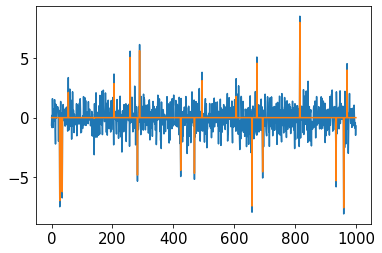

In [1924]:
plt.plot(x)
plt.plot(xhat)

In [1925]:
outlier_true_index = np.where(xhat!=0)

In [1929]:
outlier_true_index

(array([ 27,  35,  55, 140, 205, 258, 282, 289, 424, 469, 494, 606, 658,
        674, 693, 815, 934, 959, 970]),)

In [1930]:
outlier_true_value = xhat[xhat!=0]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [1931]:
outlier_true_one = xhat

In [1932]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## sklearn.neighbors.LocalOutlierFactor

### 1. sin

In [1933]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [1934]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari) 안 그리면 필요 없음

In [1935]:
_df1=pd.DataFrame({'x':_x, 'y':_y})

---

In [1936]:
X = np.array(_df)

In [1937]:
clf = LocalOutlierFactor(n_neighbors=2)

In [1938]:
clf.fit_predict(X)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

outlier

In [1939]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [1940]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [1942]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [1943]:
w=np.zeros((1000,1000))

In [1944]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1945]:
_simul = SIMUL(_df)

In [1946]:
_simul.fit()

In [1947]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [1948]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [1986]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [1987]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

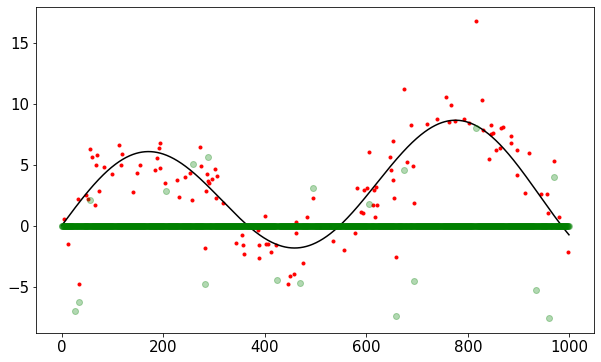

In [1988]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1,'k-')
plt.plot(xhat,'go',alpha=0.3)

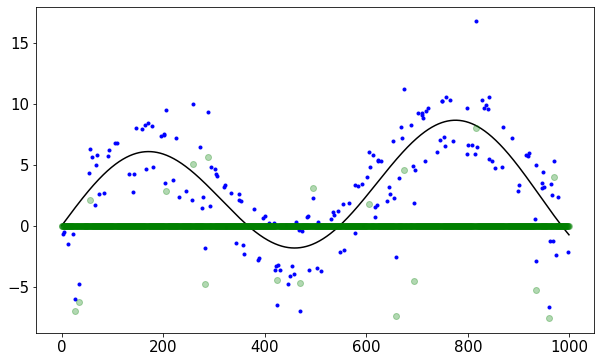

In [1989]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1,'k-')
plt.plot(xhat,'go',alpha=0.3)

In [1990]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 121, 179)

In [1991]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 11 개 detecting


In [1992]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.5789473684210527

In [1993]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [1994]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [1995]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

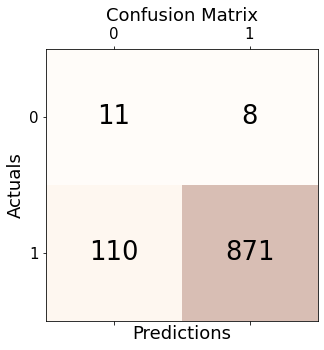

In [1996]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1997]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.5789473684210527

In [1998]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.882
Precision: 0.991
Recall: 0.888
F1 Score: 0.937


In [1999]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

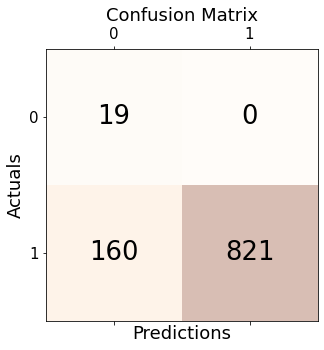

In [2000]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2001]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [2002]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.840
Precision: 1.000
Recall: 0.837
F1 Score: 0.911


### 2. two dimensional manifold

In [2157]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [2158]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [2159]:
X = np.array(_df)

In [2160]:
clf = LocalOutlierFactor(n_neighbors=2)

In [2161]:
clf.fit_predict(X)

array([ 1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1

outlier

In [2162]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [2163]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [2164]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=60): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [2165]:
_simul = SIMUL(_df)

In [2166]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 528.64it/s]


In [2167]:
_simul.get_weightmatrix(theta=(_simul.D[_simul.D>0].mean()),kappa=2500) 

In [2168]:
_simul.fit()

In [2169]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [2170]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [2171]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [2172]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

In [2173]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(43, 129, 205)

In [2174]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

43 개 outlier 중에 6 개 detecting


In [2175]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.13953488372093023

In [2176]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

43 개 outlier 중에 5 개 detecting


In [2177]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.11627906976744186

In [2180]:
 plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')

,x,y,f
3,-2.056210,-0.038763,1.878269
5,-2.093169,-0.065780,-0.348933
6,-2.111468,-0.079638,1.053180
13,-2.235359,-0.182994,-0.991325
23,-2.395249,-0.348575,0.163530
...,...,...,...
967,-1.401557,0.294843,0.783422
970,-1.453505,0.277271,7.235591
974,-1.525011,0.251370,-0.660202
978,-1.598655,0.222400,3.995305


In [2226]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=vx,
#     y=vy,
#     z=f,
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=f,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.3
#     )
# )])
# fig.add_scatter3d(x=_df.loc[outlier_first_index]['x'],y=_df.loc[outlier_first_index]['y'],z=_df.loc[outlier_first_index]['f'], mode="markers",marker=dict(size=3, color="blue"),name='f',opacity=0.5)
# fig.add_scatter3d(x=_simul.df.loc[outlier_simul_first_index]['x'],y=_simul.df.loc[outlier_simul_first_index]['y'],z=_simul.df.loc[outlier_simul_first_index]['f'], mode="markers",marker=dict(size=3, color="red"),name='f',opacity=0.5)
# fig.add_trace(go.Scatter3d(x=vx,y=vy,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene = dict(xaxis = dict(range=[-3,3],),
#                                          yaxis = dict(range=[-3,3],),
#                                          zaxis = dict(range=[-10,10],),),width=800,height=800,autosize=False)
# fig.show()

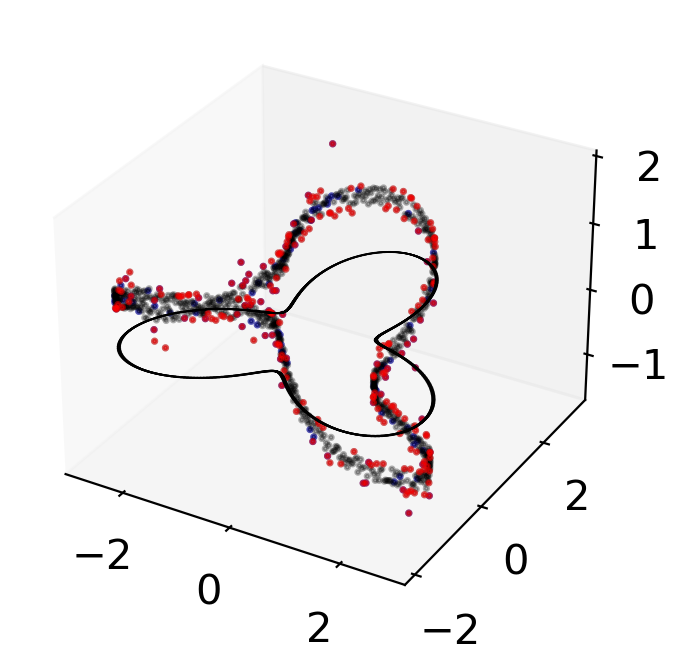

In [2217]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='black',alpha=0.3)
ax.scatter3D(_df.loc[outlier_first_index]['x'],_df.loc[outlier_first_index]['y'],_df.loc[outlier_first_index]['f'], zdir='z',s=10,marker='.',c='blue',alpha=0.5)
ax.scatter3D(_simul.df.loc[outlier_simul_first_index]['x'],_simul.df.loc[outlier_simul_first_index]['y'],_simul.df.loc[outlier_simul_first_index]['f'], zdir='z',s=10,marker='.',c='red',alpha=0.5)
ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

In [2056]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

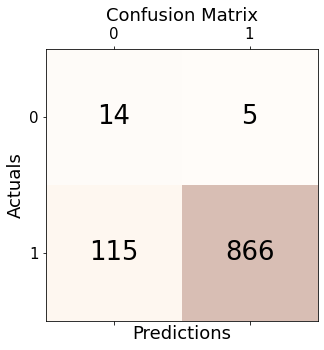

In [2057]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2058]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7368421052631579

In [2059]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.880
Precision: 0.994
Recall: 0.883
F1 Score: 0.935


In [2060]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

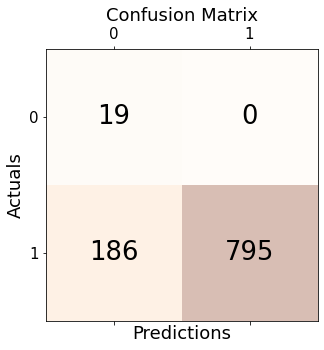

In [2061]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2062]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [2063]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.814
Precision: 1.000
Recall: 0.810
F1 Score: 0.895


### 3. Bunny

In [2064]:
G = graphs.Bunny()
n = G.N

In [2065]:
g = filters.Heat(G, tau=75) 

In [2066]:
np.random.seed(1)
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 

In [2067]:
outlier_true_index = np.where(noise>1)

In [2068]:
outlier_true_value = noise[noise>1]

In [2069]:
outlier_true_one = noise

In [2070]:
outlier_true_one = list(map(lambda x: -1 if x > 1 else 1,outlier_true_one))

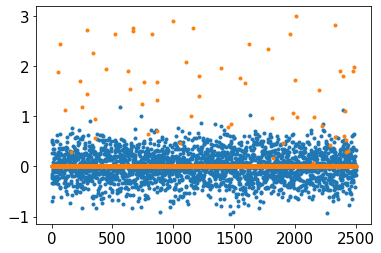

In [2071]:
plt.plot(normal,'.')
plt.plot(unif,'.')
#plt.plot(noise,'--')

In [2072]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-10-29 21:47:53,120:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [2073]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = G.coords[:,2]

In [2074]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'f' : f, 'noise' : noise})

In [2075]:
X = np.array(_df)

In [2076]:
clf = LocalOutlierFactor(n_neighbors=2)

In [2077]:
clf.fit_predict(X[:,:4])

array([1, 1, 1, ..., 1, 1, 1])

outlier

In [2078]:
outlier_first_index = np.where(clf.fit_predict(X[:,:4])==-1)

In [2079]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X[:,:4])==-1]

In [2080]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [2081]:
_simul = SIMUL(_df)

In [2082]:
_simul.fit()

In [2122]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [2123]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [2124]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [2125]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

In [2126]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(43, 33, 32)

In [2127]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

43 개 outlier 중에 0 개 detecting


In [2128]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.0

In [2129]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

43 개 outlier 중에 31 개 detecting


In [2130]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.7209302325581395

In [2131]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X[:,:4]))

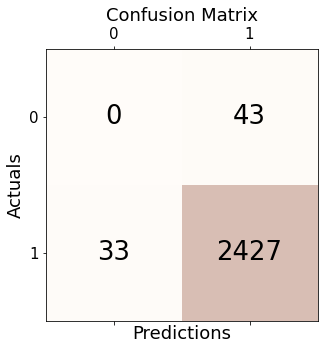

In [2132]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2133]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.0

In [2134]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X[:,:4])))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X[:,:4])))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X[:,:4])))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X[:,:4])))

Accuracy: 0.970
Precision: 0.983
Recall: 0.987
F1 Score: 0.985


In [2135]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

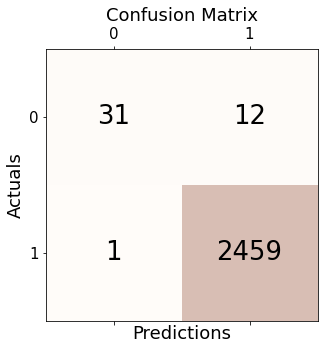

In [2136]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2137]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7209302325581395

In [2138]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.995
Precision: 0.995
Recall: 1.000
F1 Score: 0.997


---

## Robust covariance estimation and Mahalanobis distances relevance

In [1075]:
X = np.array(_df1)

In [1076]:
gen_cov = np.eye(2)
gen_cov[0, 0] = 2.0
outliers_cov = np.eye(2)
outliers_cov[np.arange(1, 2), np.arange(1, 2)] = 7.0
#X[-19:] = np.dot(np.random.randn(19, 2), outliers_cov)

In [1077]:
outlier_true_index = np.where(xhat!=0)

In [1079]:
X[outlier_true_index] = np.dot(np.random.randn(19, 2), outliers_cov)

In [1080]:
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print(
    "Estimated covariance matrix:\nMCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    ))

Estimated covariance matrix:
MCD (Robust):
[[ 0.1536288  -0.51890293]
 [-0.51890293  8.3341086 ]]
MLE:
[[ 0.38435471  0.42938002]
 [ 0.42938002 12.52298133]]


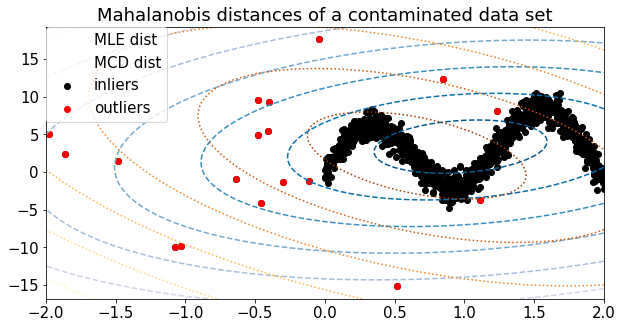

In [1081]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
outlier_plot = ax.scatter(
    X[:, 0][outlier_true_index], X[:, 1][outlier_true_index], color="red", label="outliers"
)
ax.set_xlim(-2.0, 2.0)
ax.set_title("Mahalanobis distances of a contaminated data set")
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

# Add legend
ax.legend(
    [
        emp_cov_contour.collections[1],
        robust_contour.collections[1],
        inlier_plot,
        outlier_plot,
    ],
    ["MLE dist", "MCD dist", "inliers", "outliers"],
    loc="upper left",
    borderaxespad=0,
)

plt.show()
